<a href="https://colab.research.google.com/github/lethikieuanh1204-a11y/thesis/blob/main/Thesis_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input

In [ ]:
!pip install ta

In [ ]:
import ta
import pandas as pd
import numpy as np
import yfinance as yf

# Tải dữ iliệu từ Yahoo Finance
ASSETS = ["FPT.VN", "VIC.VN", "VCB.VN", "GAS.VN", "HPG.VN"]  # Bỏ VNINDEX ra
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"

# Tạo dictionary để lưu dữ liệu từng mã
stocks_data = {}
for symbol in ASSETS:
    df = yf.download(symbol, start=START_DATE, end=END_DATE)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]  # Chọn các cột cần thiết
    stocks_data[symbol] = df

/tmp/ipython-input-2912116102.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2912116102.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2912116102.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2912116102.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-291211610

In [ ]:
for symbol, df in stocks_data.items():
    print("=" * 60)
    print(f"Dữ liệu cổ phiếu: {symbol}")
    print(df.head(10))


Dữ liệu cổ phiếu: FPT.VN
Price               Open          High           Low         Close   Volume
Ticker            FPT.VN        FPT.VN        FPT.VN        FPT.VN   FPT.VN
Date                                                                       
2020-01-02  22916.110739  23191.261068  22798.188376  23034.031250  2164345
2020-01-03  23151.952053  23230.566957  22562.343980  22640.957031  4942819
2020-01-06  22444.420732  22640.956130  22326.498381  22405.113281  2634859
2020-01-07  22523.034454  22837.492188  22405.112109  22837.492188  2020780
2020-01-08  22601.650195  22680.263242  22326.498047  22326.498047  4437500
2020-01-09  22523.036529  22680.264483  22444.421625  22640.957031  2334095
2020-01-10  22601.648438  22719.568925  22444.418651  22601.648438  2458638
2020-01-13  22562.342269  22640.955314  22405.112473  22444.419922  1993075
2020-01-14  22444.420732  22562.343083  22405.113281  22405.113281  1943884
2020-01-15  22405.113281  22444.420732  22326.498381  22405.113

In [ ]:
# Tạo DataFrame với giá đóng cửa cho từng cổ phiếu
df_close = pd.concat({tk: d['Close'] for tk, d in stocks_data.items()}, axis=1)
df_close.columns = df_close.columns.droplevel(0)  # Đổi tên cột sau khi concat

# Tính toán tỷ lệ log return hàng ngày
daily_log_returns = np.log(df_close / df_close.shift(1))

# Khởi tạo danh sách lưu trữ các đặc trưng
rows = []

# Lấy các dữ liệu đặc trưng từ mỗi cổ phiếu
for ticker in daily_log_returns.columns:
    df_feat = pd.DataFrame({
        "date": daily_log_returns.index,
        "ticker": ticker,
        "return": daily_log_returns[ticker],
        "return_lag1": daily_log_returns[ticker].shift(1),
        "return_lag5": daily_log_returns[ticker].shift(5),
        "return_lag10": daily_log_returns[ticker].shift(10),
    })

    # 1. Lợi suất & Biến động (Return & Volatility)
    df_feat["volatility"] = daily_log_returns[ticker].rolling(21).std() * np.sqrt(252)  # 21-day STD
    df_feat["ewma_volatility"] = daily_log_returns[ticker].ewm(span=21).std() * np.sqrt(252)  # EWMA volatility

    # 2. Momentum & MA/EMA
    df_feat["ret_5"] = np.log(df_close[ticker] / df_close[ticker].shift(5)) - 1  # Return tích lũy 5 ngày
    df_feat["ret_10"] = np.log(df_close[ticker] / df_close[ticker].shift(10)) - 1  # Return tích lũy 10 ngày
    df_feat["ret_21"] = np.log(df_close[ticker] / df_close[ticker].shift(21)) - 1  # Return tích lũy 21 ngày

    short_mom = df_close[ticker] / df_close[ticker].shift(5) - 1  # Momentum ngắn hạn
    long_mom  = df_close[ticker] / df_close[ticker].shift(21) - 1  # Momentum dài hạn
    df_feat["momentum_diff"] = short_mom - long_mom  # Momentum chênh lệch

    df_feat["SMA20_ratio"] = df_close[ticker] / df_close[ticker].rolling(20).mean() - 1  # SMA20 ratio
    df_feat["SMA50_ratio"] = df_close[ticker] / df_close[ticker].rolling(50).mean() - 1  # SMA50 ratio
    df_feat["EMA12_ratio"] = df_close[ticker] / df_close[ticker].ewm(span=12).mean() - 1  # EMA12 ratio
    df_feat["EMA26_ratio"] = df_close[ticker] / df_close[ticker].ewm(span=26).mean() - 1  # EMA26 ratio

    # 3. Dao động & Sức mạnh (Oscillators & Strength)
    EMA12 = df_close[ticker].ewm(span=12).mean()
    EMA26 = df_close[ticker].ewm(span=26).mean()
    df_feat["MACD"] = EMA12 - EMA26  # MACD

    df_feat["RSI14"] = ta.momentum.RSIIndicator(df_close[ticker], window=14).rsi()  # RSI14

    # Bollinger Bands
    mavg = df_close[ticker].rolling(20).mean()
    std = df_close[ticker].rolling(20).std()
    upper = mavg + 2 * std
    lower = mavg - 2 * std
    df_feat["Boll_width"] = (upper - lower) / mavg  # Bollinger width
    df_feat["Boll_percB"] = (df_close[ticker] - lower) / (upper - lower)  # Bollinger %B

    # 4. Độ rộng/Biến động Giá (Range/Price Action)
        # ATR (Average True Range)
    # Ensure high, low, close are Series for correct calculations
    high = stocks_data[ticker]["High"].squeeze()
    low = stocks_data[ticker]["Low"].squeeze()
    close = stocks_data[ticker]["Close"].squeeze()

    # Tính toán True Range (TR)
    tr = np.maximum(
      (high - low),
       np.maximum(
         (high - close.shift(1)).abs(),
         (low - close.shift(1)).abs()
       )
      )


    # Tạo Series cho TR với index từ giá đóng cửa
    tr_series = pd.Series(tr, index=close.index)

    # Tính ATR (Average True Range) theo chu kỳ 14 ngày
    df_feat["ATR"] = tr_series.rolling(14).mean() / close

    # Reindex lại theo ngày để phù hợp với dữ liệu của df_feat
    df_feat["ATR"] = df_feat["ATR"].reindex(df_feat["date"])

    rows.append(df_feat)

    # 5. Khối lượng (Volume)
    ticker_volume = stocks_data[ticker]['Volume']
    log_vol = np.log(ticker_volume.replace(0, np.nan))
    df_feat["Volume_diff"] = log_vol.diff().reindex(df_feat["date"])  # Thay đổi log-volume


# Gộp lại tất cả ticker
features = pd.concat(rows, axis=0).sort_values(["ticker", "date"]).reset_index(drop=True)

# 7) Target = return ngày kế tiếp
features = features.sort_values(["ticker", "date"])
features["target"] = features.groupby("ticker")["return"].shift(-1).rolling(5).mean()

# 8) Làm sạch dữ liệu (bỏ tất cả NaN phát sinh)
df = features.dropna().reset_index(drop=True)

# Kiểm tra kết quả cuối cùng
print("Dataset cuối cùng:", df.shape)
print(df.head())


Dataset cuối cùng: (6000, 23)
        date  ticker    return  return_lag1  return_lag5  return_lag10  \
0 2020-03-18  FPT.VN -0.002064     0.018731    -0.017562     -0.007181   
1 2020-03-19  FPT.VN -0.014568    -0.002064    -0.054614     -0.016349   
2 2020-03-20  FPT.VN  0.000000    -0.014568     0.001039     -0.011050   
3 2020-03-23  FPT.VN -0.071692     0.000000    -0.011488     -0.070979   
4 2020-03-24  FPT.VN  0.002250    -0.071692     0.018731      0.027453   

   volatility  ewma_volatility     ret_5    ret_10  ...  SMA50_ratio  \
0    0.404102         0.405355 -1.048396 -1.136883  ...    -0.108836   
1    0.404906         0.388145 -1.008351 -1.135102  ...    -0.118185   
2    0.404441         0.371495 -1.009390 -1.124053  ...    -0.114946   
3    0.460417         0.467603 -1.069593 -1.124766  ...    -0.172306   
4    0.447806         0.451072 -1.086075 -1.149969  ...    -0.166214   

   EMA12_ratio  EMA26_ratio        MACD      RSI14  Boll_width  Boll_percB  \
0    -0.039973

In [ ]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

def adf_summary_full(df):
    results = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns  # chỉ lấy cột số

    for col in numeric_cols:
        series = df[col].dropna()
        if len(series) < 20:  # bỏ qua cột có quá ít quan sát
            continue
        adf_result = adfuller(series, autolag='AIC')
        pval = adf_result[1]
        stat = adf_result[0]
        crit = adf_result[4]['5%']
        results.append({
            'Variable': col,
            'ADF Statistic': round(stat, 4),
            'p-value': round(pval, 4),
            '5% Critical Value': round(crit, 4),
            'Stationary': 'Yes' if pval < 0.05 else 'No'
        })

    return pd.DataFrame(results)

# Gọi hàm trên toàn bộ dataframe của bạn
adf_table_full = adf_summary_full(df)
print(adf_table_full)


           Variable  ADF Statistic  p-value  5% Critical Value Stationary
0            return       -14.8889      0.0             -2.862        Yes
1       return_lag1       -14.8932      0.0             -2.862        Yes
2       return_lag5       -15.0065      0.0             -2.862        Yes
3      return_lag10       -15.1533      0.0             -2.862        Yes
4        volatility        -8.6778      0.0             -2.862        Yes
5   ewma_volatility        -9.9550      0.0             -2.862        Yes
6             ret_5       -13.1056      0.0             -2.862        Yes
7            ret_10       -12.1856      0.0             -2.862        Yes
8            ret_21       -12.6193      0.0             -2.862        Yes
9     momentum_diff       -11.1106      0.0             -2.862        Yes
10      SMA20_ratio       -13.1137      0.0             -2.862        Yes
11      SMA50_ratio       -11.4886      0.0             -2.862        Yes
12      EMA12_ratio       -13.0710    

In [ ]:
features = [
    'return', 'return_lag1', 'return_lag5', 'return_lag10',
    'volatility', 'ewma_volatility', 'ret_5', 'ret_10', 'ret_21',
    'momentum_diff', 'SMA20_ratio', 'SMA50_ratio', 'EMA12_ratio', 'EMA26_ratio',
    'MACD', 'RSI14', 'Boll_width', 'Boll_percB', 'ATR', 'Volume_diff'
]

In [ ]:
# Tạo dataset chỉ gồm feature đã chọn + date + ticker
data_selected = df[['date', 'ticker', 'target'] + features].copy()

# Kiểm tra kích thước dataset mới và các cột
print("Kích thước dataset mới:", data_selected.shape)
print("\nCác cột trong dataset:")
print(data_selected.columns.tolist())

# Hiển thị 10 dòng đầu tiên của dataset đã chọn
data_selected.head()

Kích thước dataset mới: (6000, 23)

Các cột trong dataset:
['date', 'ticker', 'target', 'return', 'return_lag1', 'return_lag5', 'return_lag10', 'volatility', 'ewma_volatility', 'ret_5', 'ret_10', 'ret_21', 'momentum_diff', 'SMA20_ratio', 'SMA50_ratio', 'EMA12_ratio', 'EMA26_ratio', 'MACD', 'RSI14', 'Boll_width', 'Boll_percB', 'ATR', 'Volume_diff']


,date,ticker,target,return,return_lag1,return_lag5,return_lag10,volatility,ewma_volatility,ret_5,...,SMA20_ratio,SMA50_ratio,EMA12_ratio,EMA26_ratio,MACD,RSI14,Boll_width,Boll_percB,ATR,Volume_diff
0,2020-03-18,FPT.VN,-0.001670,-0.002064,0.018731,-0.017562,-0.007181,0.404102,0.405355,-1.048396,...,-0.080154,-0.108836,-0.039973,-0.071117,-664.429616,33.711420,0.236505,0.161089,0.043019,-0.329211
1,2020-03-19,FPT.VN,-0.001878,-0.014568,-0.002064,-0.054614,-0.016349,0.404906,0.388145,-1.008351,...,-0.086426,-0.118185,-0.045951,-0.078665,-697.801390,31.864288,0.245221,0.147560,0.042752,0.098010
2,2020-03-20,FPT.VN,-0.013919,0.000000,-0.014568,0.001039,-0.011050,0.404441,0.371495,-1.009390,...,-0.080260,-0.114946,-0.039157,-0.073163,-715.966302,31.864288,0.254202,0.184265,0.042004,-0.342830
3,2020-03-23,FPT.VN,-0.017215,-0.071692,0.000000,-0.011488,-0.070979,0.460417,0.467603,-1.069593,...,-0.137152,-0.172306,-0.090854,-0.128267,-823.864548,24.518985,0.286667,0.021563,0.048343,0.986007
4,2020-03-24,FPT.VN,-0.010172,0.002250,-0.071692,0.018731,0.027453,0.447806,0.451072,-1.086075,...,-0.127151,-0.166214,-0.076183,-0.117919,-895.880258,25.082588,0.309585,0.089285,0.049037,-0.172095



Training LSTM for FPT.VN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
FPT.VN: MAE=0.0047, RMSE=0.0062, R²=0.213, DA=72.73%

Training LSTM for GAS.VN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
GAS.VN: MAE=0.0040, RMSE=0.0050, R²=-0.281, DA=68.64%

Training LSTM for HPG.VN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
HPG.VN: MAE=0.0038, RMSE=0.0047, R²=0.318, DA=67.27%

Training LSTM for VCB.VN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
VCB.VN: MAE=0.0033, RMSE=0.0045, R²=-0.192, DA=61.36%

Training LSTM for VIC.VN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
VIC.VN: MAE=0.0037, RMSE=0.0052, R²=0.430, DA=69.09%


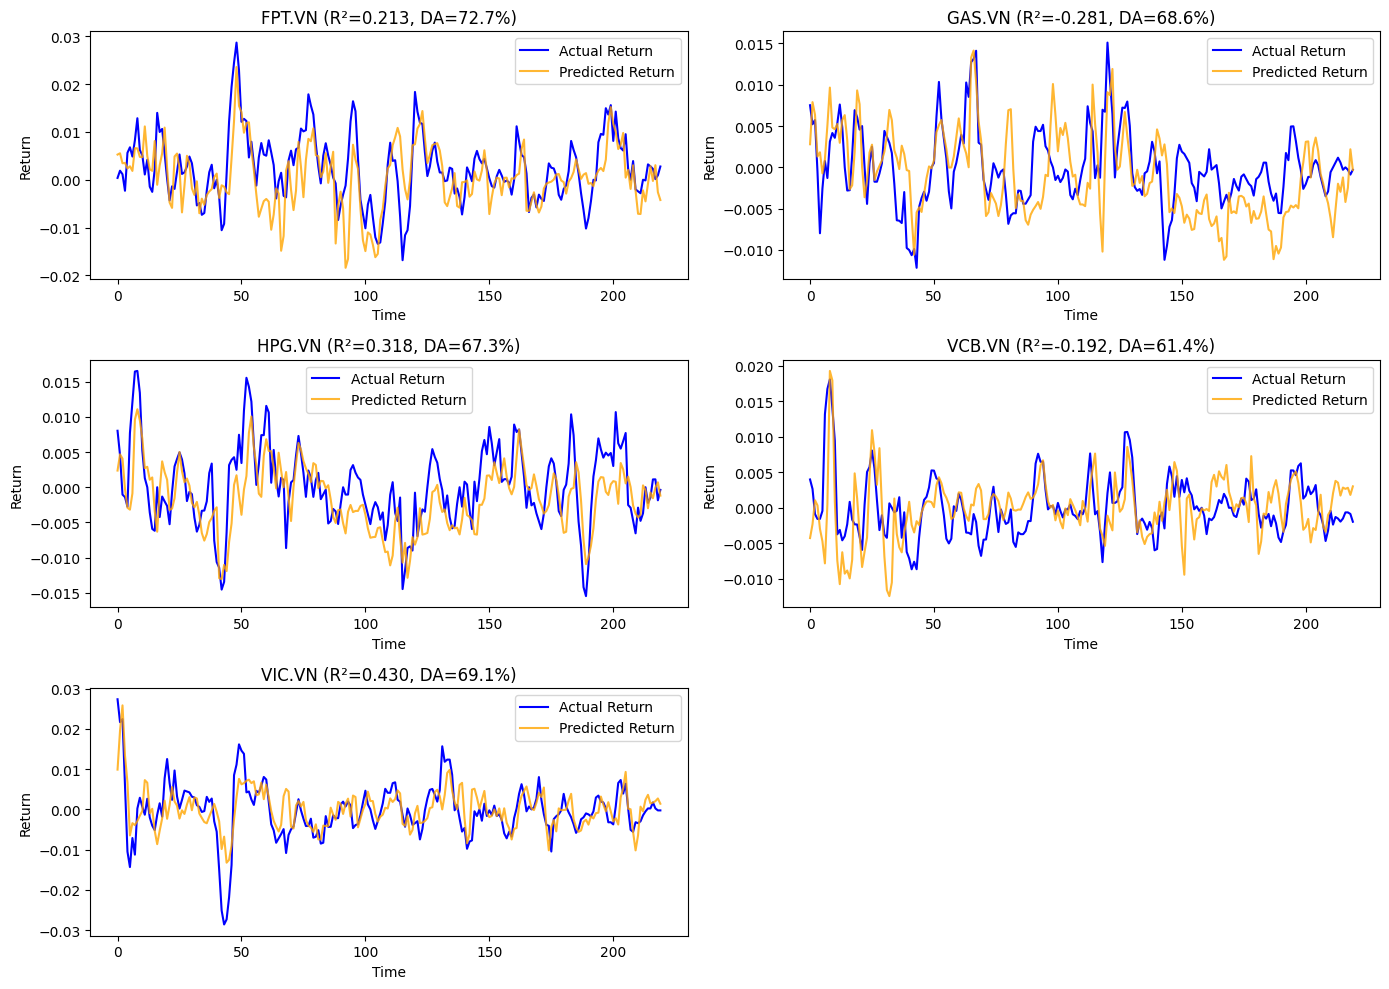


📈 Bảng dự báo từ LSTM cho FPT.VN:
           Date  Ticker    Actual  Predicted_LSTM
980  2024-02-19  FPT.VN  0.000384        0.005265
981  2024-02-20  FPT.VN  0.001898        0.005536
982  2024-02-21  FPT.VN  0.001151        0.003448
983  2024-02-22  FPT.VN -0.002297        0.003522
984  2024-02-23  FPT.VN  0.005634        0.002361
985  2024-02-26  FPT.VN  0.006787        0.002828
986  2024-02-27  FPT.VN  0.004851        0.001848
987  2024-02-28  FPT.VN  0.008241        0.006600
988  2024-02-29  FPT.VN  0.012860        0.006554
989  2024-03-01  FPT.VN  0.006199        0.004781

📈 Bảng dự báo từ LSTM cho GAS.VN:
           Date  Ticker    Actual  Predicted_LSTM
980  2024-02-19  GAS.VN  0.007519        0.002797
981  2024-02-20  GAS.VN  0.005215        0.007892
982  2024-02-21  GAS.VN  0.005730        0.006368
983  2024-02-22  GAS.VN -0.000523        0.001309
984  2024-02-23  GAS.VN -0.007975        0.001824
985  2024-02-26  GAS.VN -0.002561       -0.000726
986  2024-02-27  GAS.VN  0.000

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

SEQ_LEN = 20
TICKERS = sorted(data_selected['ticker'].unique())

# Hàm tạo sequence
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Hàm xây mô hình LSTM
def build_lstm_model(n_features):
    model = Sequential([
        LSTM(64, input_shape=(SEQ_LEN, n_features), return_sequences=False),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Huấn luyện mô hình LSTM
results_lstm = {}

for ticker in TICKERS:
    print(f"\nTraining LSTM for {ticker}")

    df_tk = data_selected[data_selected['ticker'] == ticker].copy()
    df_tk = df_tk.sort_values('date')

    X = df_tk[features].values
    y = df_tk['target'].values

    # Chia train/test theo thời gian
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Chuẩn hóa dữ liệu
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Tạo chuỗi cho LSTM
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LEN)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQ_LEN)

    # Xây và huấn luyện mô hình
    n_features = X_train_seq.shape[2]
    model = build_lstm_model(n_features)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train_seq, y_train_seq,
        validation_split=0.1,
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Dự báo và đánh giá mô hình
    y_pred = model.predict(X_test_seq).flatten()

    mae = mean_absolute_error(y_test_seq, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    r2 = r2_score(y_test_seq, y_pred)
    da = np.mean((y_test_seq > 0) == (y_pred > 0)) * 100

    results_lstm[ticker] = {
        "model": model,
        "mae": mae, "rmse": rmse, "r2": r2, "da": da,
        "y_true": y_test_seq, "y_pred": y_pred
    }

    print(f"{ticker}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.3f}, DA={da:.2f}%")

# Vẽ biểu đồ kết quả dự báo và thực tế
plt.figure(figsize=(14, 10))
for i, ticker in enumerate(TICKERS, 1):
    plt.subplot(3, 2, i)
    y_true = results_lstm[ticker]["y_true"]
    y_pred = results_lstm[ticker]["y_pred"]
    plt.plot(y_true, label="Actual Return", color='blue')
    plt.plot(y_pred, label="Predicted Return", color='orange', alpha=0.8)
    plt.title(f"{ticker} (R²={results_lstm[ticker]['r2']:.3f}, DA={results_lstm[ticker]['da']:.1f}%)")
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.legend()

plt.tight_layout()
plt.show()

# Tạo bảng kết quả dự báo cho từng cổ phiếu
for ticker in TICKERS:
    df_tk = (
        data_selected[data_selected['ticker'] == ticker]
        .sort_values('date')
        .reset_index(drop=True)
    )

    y_pred_lstm = results_lstm[ticker]['y_pred']
    y_true = results_lstm[ticker]['y_true']

    n = len(y_pred_lstm)
    dates = pd.to_datetime(df_tk['date'].iloc[-n:])

    df_results = pd.DataFrame({
        'Date': dates.dt.strftime('%Y-%m-%d'),
        'Ticker': ticker,
        'Actual': y_true,
        'Predicted_LSTM': y_pred_lstm
    })

    print(f"\n📈 Bảng dự báo từ LSTM cho {ticker}:")
    print(df_results.head(10))

    # Lưu kết quả vào file CSV nếu cần
    # df_results.to_csv(f"{ticker}_lstm_predictions.csv", index=False)


In [ ]:
# In kết quả dự báo từ LSTM với đầy đủ ngày tháng và mã cổ phiếu
for ticker in TICKERS:
    # 1. Lấy dữ liệu của ticker và sort theo ngày
    df_tk = (
        data_selected[data_selected['ticker'] == ticker]
        .sort_values('date')
        .reset_index(drop=True)
    )

    # 2. Lấy kết quả dự báo
    y_pred_lstm = results_lstm[ticker]['y_pred']
    y_true      = results_lstm[ticker]['y_true']

    n = len(y_pred_lstm)

    # 3. Lấy đúng các ngày tương ứng với tập test
    dates = pd.to_datetime(df_tk['date'].iloc[-n:])

    # 4. Tạo DataFrame kết quả
    df_results = pd.DataFrame({
        'Date': dates.dt.strftime('%Y-%m-%d'),  # hoặc bỏ .strftime nếu muốn datetime
        'Ticker': ticker,
        'Actual': y_true,
        'Predicted_LSTM': y_pred_lstm
    })

    # 5. In kết quả
    print(f"\n📈 Bảng dự báo từ LSTM cho {ticker}:")
    print(df_results.head(10))

    # 6. (Optional) Lưu CSV
    # df_results.to_csv(f"{ticker}_lstm_predictions.csv", index=False)



📈 Bảng dự báo từ LSTM cho FPT.VN:
           Date  Ticker    Actual  Predicted_LSTM
980  2024-02-19  FPT.VN  0.000384        0.005265
981  2024-02-20  FPT.VN  0.001898        0.005536
982  2024-02-21  FPT.VN  0.001151        0.003448
983  2024-02-22  FPT.VN -0.002297        0.003522
984  2024-02-23  FPT.VN  0.005634        0.002361
985  2024-02-26  FPT.VN  0.006787        0.002828
986  2024-02-27  FPT.VN  0.004851        0.001848
987  2024-02-28  FPT.VN  0.008241        0.006600
988  2024-02-29  FPT.VN  0.012860        0.006554
989  2024-03-01  FPT.VN  0.006199        0.004781

📈 Bảng dự báo từ LSTM cho GAS.VN:
           Date  Ticker    Actual  Predicted_LSTM
980  2024-02-19  GAS.VN  0.007519        0.002797
981  2024-02-20  GAS.VN  0.005215        0.007892
982  2024-02-21  GAS.VN  0.005730        0.006368
983  2024-02-22  GAS.VN -0.000523        0.001309
984  2024-02-23  GAS.VN -0.007975        0.001824
985  2024-02-26  GAS.VN -0.002561       -0.000726
986  2024-02-27  GAS.VN  0.000

In [ ]:
ticker = 'VCB.VN'

# 1. Lấy dữ liệu VCB và sort theo ngày
df_tk = (
    data_selected[data_selected['ticker'] == ticker]
    .sort_values('date')
    .reset_index(drop=True)
)

# 2. Lấy kết quả LSTM
y_pred_lstm = results_lstm[ticker]['y_pred']
y_true      = results_lstm[ticker]['y_true']

n = len(y_pred_lstm)

# 3. LẤY ĐÚNG NGÀY TEST (cột date, không phải index)
dates = pd.to_datetime(df_tk['date'].iloc[-n:])

# 4. Tạo bảng kết quả
df_results = pd.DataFrame({
    'Date': dates,                # hoặc dates.dt.strftime('%Y-%m-%d')
    'Ticker': ticker,
    'Actual': y_true,
    'Predicted_LSTM': y_pred_lstm
})

# 5. In kiểm tra
print(f"\nBảng dự báo từ LSTM cho {ticker}:")
print(df_results.head(10))



Bảng dự báo từ LSTM cho VCB.VN:
          Date  Ticker    Actual  Predicted_LSTM
980 2024-02-19  VCB.VN  0.003982       -0.004255
981 2024-02-20  VCB.VN  0.002649       -0.002312
982 2024-02-21  VCB.VN -0.000892        0.001057
983 2024-02-22  VCB.VN -0.001569        0.000336
984 2024-02-23  VCB.VN -0.001558       -0.002970
985 2024-02-26  VCB.VN -0.000439       -0.004707
986 2024-02-27  VCB.VN  0.013154       -0.007817
987 2024-02-28  VCB.VN  0.016712        0.000489
988 2024-02-29  VCB.VN  0.018057        0.019246
989 2024-03-01  VCB.VN  0.014022        0.017915


In [ ]:
df_results.head(10)

,Date,Ticker,Actual,Predicted_LSTM
980,2024-02-19,VCB.VN,0.003982,-0.004255
981,2024-02-20,VCB.VN,0.002649,-0.002312
982,2024-02-21,VCB.VN,-0.000892,0.001057
983,2024-02-22,VCB.VN,-0.001569,0.000336
984,2024-02-23,VCB.VN,-0.001558,-0.002970
985,2024-02-26,VCB.VN,-0.000439,-0.004707
986,2024-02-27,VCB.VN,0.013154,-0.007817
987,2024-02-28,VCB.VN,0.016712,0.000489
988,2024-02-29,VCB.VN,0.018057,0.019246
989,2024-03-01,VCB.VN,0.014022,0.017915


In [ ]:
!pip install PyPortfolioOpt

In [ ]:
# ===== 1. TẠO DATAFRAME DỰ BÁO LSTM (WIDE FORMAT) =====

pred_list = []

for ticker in TICKERS:
    df_tk = (
        data_selected[data_selected['ticker'] == ticker]
        .sort_values('date')
        .reset_index(drop=True)
    )

    y_pred = results_lstm[ticker]['y_pred']
    n = len(y_pred)

    dates = pd.to_datetime(df_tk['date'].iloc[-n:])

    df_tmp = pd.DataFrame({
        "date": dates,
        "ticker": ticker,
        "predicted_return": y_pred
    })

    pred_list.append(df_tmp)

pred_long = pd.concat(pred_list, ignore_index=True)

# pivot: index = date, columns = ticker
pred_df = pred_long.pivot(
    index="date",
    columns="ticker",
    values="predicted_return"
).sort_index()

print("Predicted return matrix shape:", pred_df.shape)
pred_df.head()


Predicted return matrix shape: (220, 5)


ticker,FPT.VN,GAS.VN,HPG.VN,VCB.VN,VIC.VN
date,,,,,
2024-02-19,0.005265,0.002797,0.002372,-0.004255,0.009884
2024-02-20,0.005536,0.007892,0.004687,-0.002312,0.019549
2024-02-21,0.003448,0.006368,0.004071,0.001057,0.025841
2024-02-22,0.003522,0.001309,-0.000250,0.000336,0.013412
2024-02-23,0.002361,0.001824,-0.002922,-0.002970,0.006680


[CHECK] Baseline LSTM prediction table (aligned):
              FPT.VN    GAS.VN    HPG.VN    VCB.VN    VIC.VN
2024-02-19  0.005265  0.002797  0.002372 -0.004255  0.009884
2024-02-20  0.005536  0.007892  0.004687 -0.002312  0.019549
2024-02-21  0.003448  0.006368  0.004071  0.001057  0.025841
2024-02-22  0.003522  0.001309 -0.000250  0.000336  0.013412
2024-02-23  0.002361  0.001824 -0.002922 -0.002970  0.006680
              FPT.VN    GAS.VN    HPG.VN    VCB.VN    VIC.VN
2024-12-24  0.002852 -0.001221 -0.000739  0.002844  0.001488
2024-12-25 -0.000248 -0.004189 -0.001565  0.002657  0.001698
2024-12-26  0.003045 -0.002464 -0.000040  0.002817  0.002053
2024-12-27 -0.002599  0.002189  0.000700  0.001812  0.002718
2024-12-30 -0.004232 -0.000322 -0.001192  0.003012  0.001408

Prediction range: 2024-02-19 00:00:00 → 2024-12-30 00:00:00
Shape: (220, 5)

Prediction matrix shape: (220, 6)
        date    FPT.VN    GAS.VN    HPG.VN    VCB.VN    VIC.VN
0 2024-02-19  0.005265  0.002797  0.002372 

<Figure size 1400x600 with 0 Axes>

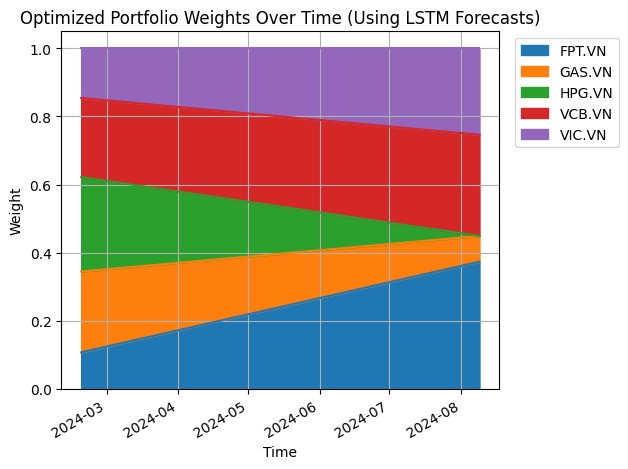

In [ ]:
# === PORTFOLIO OPTIMIZATION LIBRARIES ===
import numpy as np
import pandas as pd
import cvxpy as cp
from pypfopt import risk_models
from pypfopt.efficient_frontier import EfficientFrontier
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. CHUẨN BỊ DỮ LIỆU CƠ BẢN
# Tạo DataFrame df_close từ giá đóng cửa của tất cả cổ phiếu trong danh mục
df_close = pd.concat({tk: d['Close'] for tk, d in stocks_data.items()}, axis=1).sort_index()

# Đổi tên cột sau khi concat để loại bỏ cấp đầu tiên (tickers)
df_close.columns = df_close.columns.droplevel(0)

# Tính toán tỷ lệ log return hàng ngày
daily_log_returns = np.log(df_close / df_close.shift(1))
daily_log_returns = daily_log_returns.sort_index()

WINDOW = 120          # số ngày quá khứ ước lượng covariance
HOLDING_PERIOD = 120  # tối ưu mỗi 120 ngày
RISK_AVERSION = 1.0   # λ của quadratic utility
RF_ANNUAL = 0.03      # lãi suất phi rủi ro
TRADING_DAYS = 252    # số ngày trade/năm

# 2. XÂY BẢNG DỰ BÁO TỪ LSTM
pred_series_list = []

for ticker in TICKERS:
    df_tk = data_selected[data_selected['ticker'] == ticker].sort_values('date').reset_index(drop=True)

    # Chia lại train/test giống lúc train
    N = len(df_tk)
    split_index = int(N * 0.8)
    test_dates_full = pd.to_datetime(df_tk['date'].iloc[split_index:])

    # Với SEQ_LEN, các y_test_seq và y_pred bắt đầu từ phần tử thứ SEQ_LEN của test set
    test_dates = test_dates_full.iloc[SEQ_LEN:]

    y_pred = results_lstm[ticker]['y_pred']

    # Phòng trường hợp lệch 1–2 điểm do rounding split_index
    min_len = min(len(test_dates), len(y_pred))
    test_dates = test_dates.iloc[-min_len:]
    y_pred = y_pred[-min_len:]

    s_pred = pd.Series(data=y_pred, index=test_dates, name=ticker)
    pred_series_list.append(s_pred)

pred_df_baseline = pd.concat(pred_series_list, axis=1).sort_index()
pred_df_baseline = pred_df_baseline[~pred_df_baseline.index.duplicated(keep='first')]

# Chỉ giữ những ngày có trong log_returns để tối ưu chắc chắn match
pred_df_baseline = pred_df_baseline.loc[pred_df_baseline.index.intersection(daily_log_returns.index)]

print("[CHECK] Baseline LSTM prediction table (aligned):")
print(pred_df_baseline.head())
print(pred_df_baseline.tail())
print("\nPrediction range:", pred_df_baseline.index.min(), "→", pred_df_baseline.index.max())
print("Shape:", pred_df_baseline.shape)

# 1) Create Forecast Matrix from LSTM Predictions

pred_dict = {}

# Loop through all tickers to get predictions
for ticker in TICKERS:
    df_tk = data_selected[data_selected['ticker'] == ticker].copy()
    df_tk = df_tk.sort_values("date").reset_index(drop=True)

    n = len(df_tk)
    split_idx = int(n * 0.8)
    dates_test = df_tk.loc[split_idx + SEQ_LEN:, "date"].reset_index(drop=True)

    # Store the predictions for the ticker
    pred_dict[ticker] = pd.DataFrame({
        "date": dates_test,
        "pred_return": results_lstm[ticker]["y_pred"]
    })

# Merge the prediction data for all tickers into a single matrix
pred_matrix = pred_dict[TICKERS[0]].copy()
pred_matrix.rename(columns={"pred_return": TICKERS[0]}, inplace=True)

# Add the predictions for the other tickers
for ticker in TICKERS[1:]:
    pred_matrix = pred_matrix.merge(
        pred_dict[ticker].rename(columns={"pred_return": ticker}),
        on="date",
        how="inner"
    )

# Sort by date and reset the index for consistency
pred_matrix = pred_matrix.sort_values("date").reset_index(drop=True)

print("\nPrediction matrix shape:", pred_matrix.shape)
print(pred_matrix.head())

# 2) Portfolio Optimization Using LSTM Forecasts
def optimize_portfolio_rolling_120day_v2(
    log_returns,  # Historical returns for risk models
    predicted_returns,  # Forecasted returns (from LSTM)
    window=120,  # Rolling window for covariance estimation
    holding_period=120,  # Hold for 120 days
    risk_aversion=1.0  # Risk aversion factor (lambda)
):
    tickers = predicted_returns.columns
    optimization_dates = predicted_returns.index[::holding_period]

    weights_history = pd.DataFrame(index=optimization_dates, columns=tickers, dtype=float)
    pnl_daily = pd.Series(0.0, index=log_returns.index)

    for opt_date in optimization_dates:
        if opt_date not in log_returns.index:
            continue

        try:
            # 1. Past covariance (daily log-return)
            past_returns = log_returns.loc[:opt_date].iloc[-window:]
            if len(past_returns) < 50:
                continue

            S = risk_models.sample_cov(past_returns)

            # 2. Expected return (LSTM forecast)
            mu = predicted_returns.loc[opt_date].dropna()

            common_assets = S.index.intersection(mu.index)
            if len(common_assets) == 0:
                continue

            S_opt = S.loc[common_assets, common_assets]
            mu_opt = mu.loc[common_assets]

            # 3. Markowitz utility (quadratic utility maximization)
            ef = EfficientFrontier(mu_opt, S_opt, solver=cp.OSQP)
            ef.max_quadratic_utility(risk_aversion=risk_aversion)
            w_raw = ef.clean_weights()

            # 4. Expand weights back to the full list of tickers
            w_full = pd.Series(0.0, index=tickers, dtype=float)
            w_full.update(pd.Series(w_raw))
            if w_full.sum() > 0:
                w_full /= w_full.sum()  # Ensure the weights sum to 1

            # 5. Backtest the portfolio for the holding period (5 days)
            weights_history.loc[opt_date] = w_full

            start = log_returns.index.get_loc(opt_date) + 1
            end = start + holding_period
            hold_slice = log_returns.iloc[start:end]

            if hold_slice.empty:
                continue

            daily_ret = hold_slice.dot(w_full)
            pnl_daily.loc[daily_ret.index] = daily_ret.values

        except Exception as e:
            print(f"Optimization error at {opt_date}: {e}")
            continue

    pnl_daily = pnl_daily[pnl_daily.index >= predicted_returns.index.min()]
    pnl_daily = pnl_daily.dropna()

    return weights_history.dropna(how="all"), pnl_daily

def compute_performance_metrics(pnl):
    # Annualized Return
    ann_return = pnl.mean() * TRADING_DAYS

    # Annualized Volatility
    ann_vol = pnl.std() * np.sqrt(TRADING_DAYS)

    # Sharpe Ratio
    sharpe_ratio = (ann_return - RF_ANNUAL) / ann_vol

    # Max Drawdown
    cumulative_returns = (1 + pnl).cumprod()
    peak = cumulative_returns.expanding(min_periods=1).max()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    return {
        "Ann_Return": ann_return,
        "Ann_Vol": ann_vol,
        "Sharpe": sharpe_ratio,
        "Max_Drawdown": max_drawdown
    }

# Run the rolling optimization using the forecasted returns from LSTM
weights_optimized, pnl_optimized = optimize_portfolio_rolling_120day_v2(
    log_returns=daily_log_returns,
    predicted_returns=pred_matrix.set_index('date'),
    window=WINDOW,
    holding_period=HOLDING_PERIOD,
    risk_aversion=RISK_AVERSION
)

# Display portfolio performance
print("\nOptimized Portfolio Performance:")
stats_opt = compute_performance_metrics(pnl_optimized)
print(stats_opt)

# 8. Create Portfolio Weights and Performance Table
# Calculate the average weights for each asset
weights_avg = weights_optimized.mean(axis=0) * 100  # Convert to percentage

# Prepare performance metrics
performance_metrics = {
    "Expected Return (Annualized)": f"{stats_opt['Ann_Return']*100:.2f}%",
    "Volatility (Annualized)": f"{stats_opt['Ann_Vol']*100:.2f}%",
    "Sharpe Ratio": f"{stats_opt['Sharpe']:.4f}",
    "Max Drawdown": f"{stats_opt['Max_Drawdown']*100:.2f}%"  # Convert to percentage
}

# Create the table for asset weights
weights_table = pd.DataFrame({
    "Item": ["**Asset Weights (Average)"] + list(weights_avg.index) + ["---", "Total Average Weight"],
    "Value": [""] + list(weights_avg.round(2)) + [""] + [100.0]  # Total weight will always be 100%
})

# Create the table for performance metrics
performance_table = pd.DataFrame({
    "Item": ["**Portfolio Performance"] + list(performance_metrics.keys()),
    "Value": [""] + list(performance_metrics.values())
})

# Combine both tables
final_table = pd.concat([weights_table, performance_table], ignore_index=True)

# Print the final table
print("\n===== Table: Average Optimal Portfolio Weights and Performance Metrics (Hybrid 5-Day) =====")
print(final_table.to_string(index=False))

# 9. Row Sums of Hybrid Weights Check
# Check if the sum of weights for each row (each optimization date) is ~1
row_sums = weights_optimized.sum(axis=1)

# Print the summary statistics of the row sums to check they sum to 1
print("\n[CHECK] Row sums of Hybrid weights (should be ~1):")
print(row_sums.describe())

# 10. Visualize Portfolio Weights
plt.figure(figsize=(14, 6))
weights_optimized.plot.area(stacked=True)
plt.title("Optimized Portfolio Weights Over Time (Using LSTM Forecasts)")
plt.xlabel("Time")
plt.ylabel("Weight")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


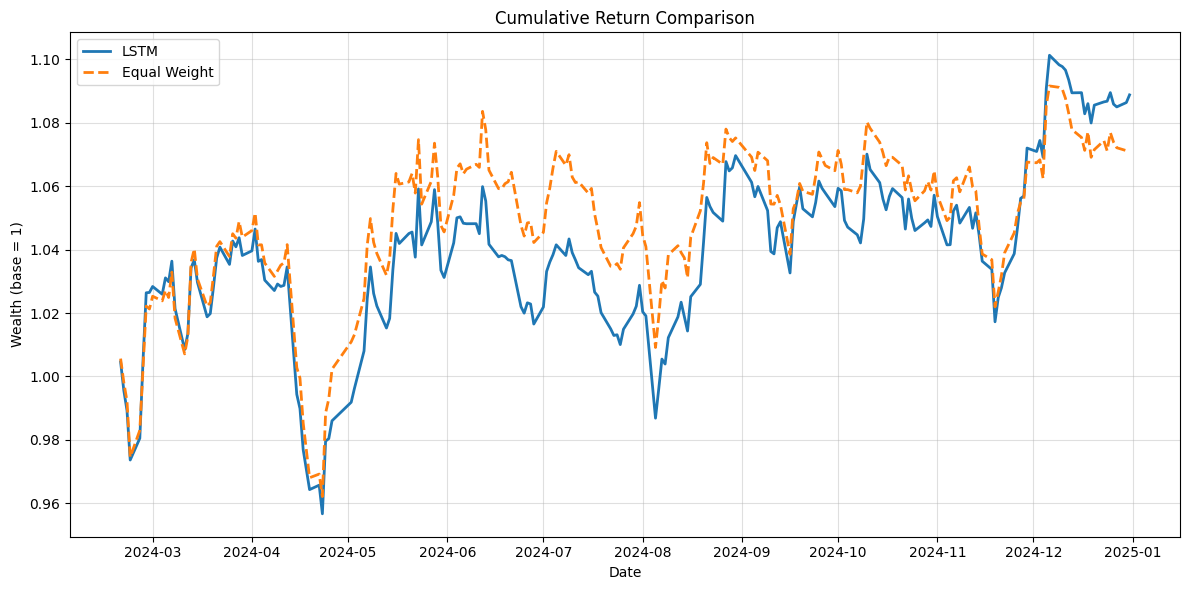

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(
    np.exp(pnl_lstm.cumsum()),
    label="LSTM",
    linewidth=2
)

plt.plot(
    np.exp(eq_ret_daily.cumsum()),
    label="Equal Weight",
    linestyle="--",
    linewidth=2
)

plt.title("Cumulative Return Comparison")
plt.ylabel("Wealth (base = 1)")
plt.xlabel("Date")
plt.grid(alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()
